<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeAutomatizado/blob/master/notebooks/3c_regresion_lineal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresión lineal

Curso: [Aprendizaje Automatizado](http://turing.iimas.unam.mx/~gibranfp/cursos/aprendizaje_automatizado). Profesor: [Gibran Fuentes Pineda](https://turing.iimas.unam.mx/~gibranfp/). Ayudantes: [Bere](https://turing.iimas.unam.mx/~bereml/) y [Ricardo](https://turing.iimas.unam.mx/~ricardoml/) Montalvo Lezama.

---
---

![xkcd-linreg](https://imgs.xkcd.com/comics/linear_regression.png)

https://xkcd.com/1725/

En esta libreta veremos un ejemplo paso a paso del modelo de regresión lineal con dos atributos de entrada y una salida. Emplearemos un conjunto de calificaciones de alumnos posgrado que tomaron primero el curso de Aprendizaje de Automatizado y después el curso de Aprendizaje Profundo. El conjunto tiene dos atributos: la calificación obtenida en el curso de Aprendizaje de Automatizado y el número de horas de estudio para el examen del curso de Aprendizaje Profundo. Como salida se tiene la calificación obtenida en examen de Aprendizaje Profundo.

## 1. Preparación

In [1]:
# para correr con widgets en local instalar jupyter-matplotlib
# https://github.com/matplotlib/jupyter-matplotlib
# descomentar la siguiente linea y correr de nuevo toda la libreta
#%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

## 2. Carga de datos

Leamos con Pandas:

In [2]:
URL = 'https://raw.githubusercontent.com/gibranfp/CursoAprendizajeAutomatizado/master/data/califs.csv'
df = pd.read_csv(URL)
df.head(5)

,prev,horas,calif
0,5.6,8.2,5.1
1,6.7,9.3,5.9
2,5.1,10.0,5.4
3,5.7,10.4,6.5
4,7.1,10.4,6.7


Conversión de numpy:

In [3]:
x = df.iloc[:,:2].values
print(x.shape)
x[:5]

(50, 2)


array([[ 5.6,  8.2],
       [ 6.7,  9.3],
       [ 5.1, 10. ],
       [ 5.7, 10.4],
       [ 7.1, 10.4]])

In [4]:
y_true = df.iloc[:,2].values
print(y_true.shape)
y_true[:5]

(50,)


array([5.1, 5.9, 5.4, 6.5, 6.7])

Construcción de la matriz de diseño:

In [5]:
ones = np.ones([x.shape[0], 1])
x = np.hstack([ones, x])
print(x.shape)
x[:5]

(50, 3)


array([[ 1. ,  5.6,  8.2],
       [ 1. ,  6.7,  9.3],
       [ 1. ,  5.1, 10. ],
       [ 1. ,  5.7, 10.4],
       [ 1. ,  7.1, 10.4]])

Guardamos número de atributos y ejemplos:

In [6]:
m, n = x.shape
m, n

(50, 3)

## 3. Exploración

Grafiquemos para tener una idea de la distribución de los datos:

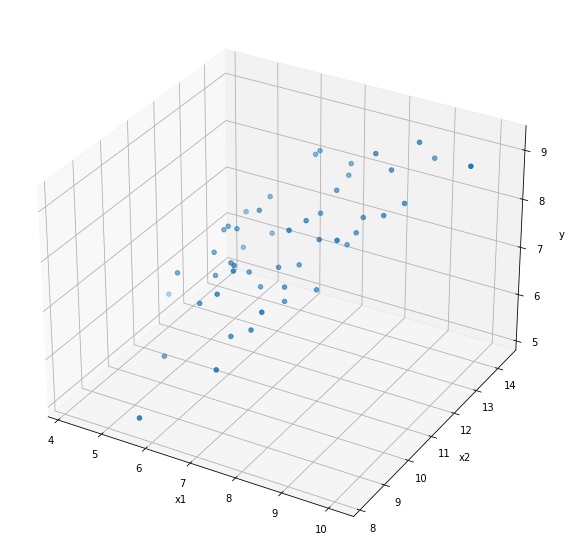

In [7]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:, 1], x[:, 2], y_true,
           color='tab:blue')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.show()

## 4. Hipótesis

Recordemos que dado un conjunto de ejemplos con atributos $x_1, x_2$ y salida $y$, la hipótesis de regresión lineal considerando un plano está dada por:

$$\hat{y} = \theta_0 + x_1 \theta_1 + x_2 \theta_2$$

donde $\theta_0, \theta_1, \theta_2$ son parámetros del modelo y $\hat{y}$ la salida predicha. Empleando la matriz de diseño, podemos expresar la hipótesis en su forma vectorial:

$$\hat{y} = x \theta$$

Nuestro trabajo consiste en estimar (aprender) los parámetros $\theta_0, \theta_1, \theta_2$. Por el momento supongamos que un oráculo nos regalo los siguientes valores para los parámetros y hagamos inferencia:

In [8]:
t = np.array([1.7071569, 0.13335178, 0.41122846])

y_pred = []
for i in range(m):
    y_p = t[0] + x[i, 1] * t[1] + x[i, 2] * t[2]
    y_pred.append(y_p)
y_pred = np.array(y_pred)
y_pred[:5]

array([5.82600024, 6.4250385 , 6.49953558, 6.74403803, 6.93073052])

Implementando la forma vectorial:

In [9]:
y_pred = x @ t
y_pred[:5]

array([5.82600024, 6.4250385 , 6.49953558, 6.74403803, 6.93073052])

Grafiquemos el plano correspondiente a los parámetros propuestos:

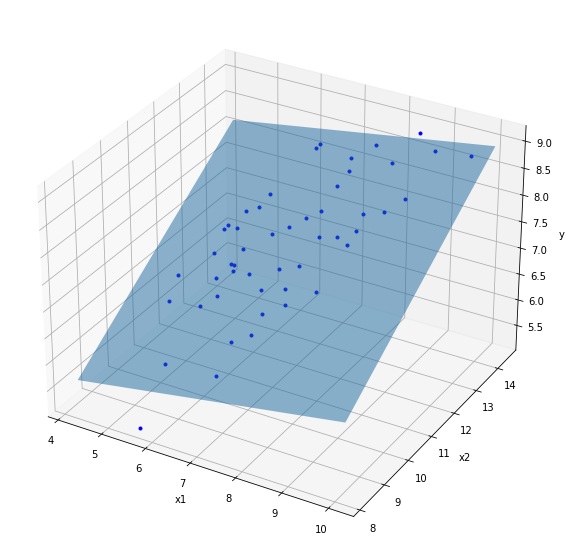

In [10]:
x1 = np.linspace(x[:,1].min(), x[:,1].max(), 2)
x2 = np.linspace(x[:,2].min(), x[:,2].max(), 2)
x1, x2 = np.meshgrid(x1, x2)
y_pred = t[0] + t[1] * x1 + t[2] * x2

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1, x2, y_pred, rstride=1, cstride=1, alpha=0.5)
ax.plot(x[:, 1], x[:, 2], y_true, 'b.')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.show()

## 5. Función de pérdida

La pérdida para este modelo es el error cuadrático medio y queda expresado de la siguiente manera:

$$ J(\mathbf{\theta}) = \frac{1}{2m}  \sum_{i=1}^{m}{(\hat{y}^{(i)} - y^{(i)})^2} $$

en su forma vectorial:

$$ J(\mathbf{\theta}) = \frac{1}{2m} (\hat{y} - y)^T (\hat{y} - y) $$

Para los parámetros propuestos, la pérdida se puede implementar como:

In [11]:
# recomputamos las predicciones de los datos
y_pred = x @ t

loss = 0
for i in range(m):
    loss += (y_pred[i] - y_true[i])**2
loss /= 2 * m
loss

0.1416369054735457

y en su forma vectorial:

In [12]:
loss = (y_pred - y_true).T @ (y_pred - y_true) / (2 * m)
loss

0.14163690547354574

## 6. Descenso por gradiente

![graddes](https://ml-cheatsheet.readthedocs.io/en/latest/_images/gradient_descent_demystified.png)

Imagen tomada de https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html

El algoritmo del descenso por gradiente se basa en el gradiente de la pérdida respecto de los parámetros:

$$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m}{(\hat{y}^{(i)} - y^{(i)})x^{(i)}_j}$$

en su forma vectorial:

$$\Delta J(\theta) = \frac{1}{m} x^T (\hat{y} - y)$$

Para los parámetros propuestos, el cómputo gradiente se puede implementar como:

In [13]:
grad = [0, 0, 0]
for j in range(len(grad)):
    for i in range(m):
        grad[j] += (y_pred[i] - y_true[i]) * x[i, j]
    grad[j] /= m
np.array(grad)

array([0.25249031, 1.50161512, 2.81670065])

y en su forma vectorial:

In [14]:
grad = (x.T @ (y_pred - y_true)) / m
grad

array([0.25249031, 1.50161512, 2.81670065])

Con base en el gradiente, la regla de actualización del descenso por gradiente queda expresada como:

$$\theta_j^{(t+1)} \leftarrow \theta_j^{(t)}  - \alpha \frac{\partial J(\theta^{(t)})}{\partial \theta_j^{(t)}}$$

mientras que su forma vectorial:

$$\theta^{(t+1)} \leftarrow \theta^{(t)}  - \alpha \Delta J(\theta^{(t)})$$

Para los parámetros propuestos y datos, el gradiente se puede implementar como:

In [15]:
alpha = 0.001

t_next = []
for t_j, g_j in zip(t, grad):
    t_j_next = t_j - alpha * g_j
    t_next.append(t_j_next)
t = np.array(t_next)
t

array([1.70690441, 0.13185016, 0.40841176])

y su forma vectorial:

In [16]:
# reniniciamos los parámetros
t = np.array([1.7071569, 0.13335178, 0.41122846])

t = t - alpha * grad
t

array([1.70690441, 0.13185016, 0.40841176])

## 7. Entrenamiento

Realicemos 3 pasos del descenso por gradiente estocástico con lotes de 2 de forma manual. Primero inicialicemos de nuevo nuestros parámetros y tasa de aprendizaje: 

In [17]:
alpha = 0.001
np.random.seed(0)
t = np.random.normal(0, 1, n)
t

array([1.76405235, 0.40015721, 0.97873798])

Computemos la pérdida total de los datos y mantengamos un historial:

In [18]:
y_pred = x @ t
loss = (y_pred - y_true).T @ (y_pred - y_true) / (2 * m)
loss_hist = [loss]
loss_hist

[40.18335645409401]

### 7.1. Paso 1

A) Selección del lote:

In [19]:
examples = [0, 24]
m_batch = len(examples)
x_batch = x[examples]
x_batch

array([[ 1. ,  5.6,  8.2],
       [ 1. ,  5.7, 11.9]])

In [ ]:
y_true_batch = y_true[examples]
y_true_batch

array([5.1, 7.4])

B) Predicciones:

$$\hat{y} = x \theta$$

In [ ]:
y_pred_batch = x_batch @ t
y_pred_batch

C) Pérdida:

$$ J(\mathbf{\theta}) = \frac{1}{2m} (\hat{y} - y)^T (\hat{y} - y) $$

In [ ]:
loss_batch = (y_pred_batch - y_true_batch).T @ (y_pred_batch - y_true_batch) / (2 * m_batch)
loss_batch

D) Gradiente:

$$\Delta J(\theta) = \frac{1}{m} x^T (\hat{y} - y)$$

In [ ]:
grad_batch = (x_batch.T @ (y_pred_batch - y_true_batch)) / m_batch
grad_batch

E) Parámetros actualizados:

$$\theta^{(t+1)} \leftarrow \theta^{(t)}  - \alpha \Delta J(\theta^{(t)})$$

In [ ]:
t = t - alpha * grad_batch
t

F) Actualicemos el historial de pérdidas:

In [ ]:
y_pred = x @ t
loss = (y_pred - y_true).T @ (y_pred - y_true) / (2 * m)
loss_hist.append(loss)
loss_hist

### 7.2 Paso 2

A) Selección del lote:

In [ ]:
examples = [8, 32]
m_batch = len(examples)
x_batch = x[examples]
x_batch

In [ ]:
y_true_batch = y_true[examples]
y_true_batch

B) Predicciones:

$$\hat{y} = x \theta$$

In [ ]:
y_pred_batch = x_batch @ t
y_pred_batch

C) Pérdida:

$$ J(\mathbf{\theta}) = \frac{1}{2m} (\hat{y} - y)^T (\hat{y} - y) $$

In [ ]:
loss_batch = (y_pred_batch - y_true_batch).T @ (y_pred_batch - y_true_batch) / (2 * m_batch)
loss_batch

D) Gradiente:

$$\Delta J(\theta) = \frac{1}{m} x^T (\hat{y} - y)$$

In [ ]:
grad_batch = (x_batch.T @ (y_pred_batch - y_true_batch)) / m_batch
grad_batch

E) Parámetros actualizados:

$$\theta^{(t+1)} \leftarrow \theta^{(t)}  - \alpha \Delta J(\theta^{(t)})$$

In [ ]:
t = t - alpha * grad_batch
t

F) Actualicemos el historial de pérdidas:

In [ ]:
y_pred = x @ t
loss = (y_pred - y_true).T @ (y_pred - y_true) / (2 * m)
loss_hist.append(loss)
loss_hist

### 7.3. Paso 3

A) Selección del lote:

In [ ]:
examples = [16, 40]
m_batch = len(examples)
x_batch = x[examples]
x_batch

In [ ]:
y_true_batch = y_true[examples]
y_true_batch

B) Predicciones:

$$\hat{y} = x \theta$$

In [ ]:
y_pred_batch = x_batch @ t
y_pred_batch

C) Pérdida:

$$ J(\mathbf{\theta}) = \frac{1}{2m} (\hat{y} - y)^T (\hat{y} - y) $$

In [ ]:
loss_batch = (y_pred_batch - y_true_batch).T @ (y_pred_batch - y_true_batch) / (2 * m_batch)
loss_batch

D) Gradiente:

$$\Delta J(\theta) = \frac{1}{m} x^T (\hat{y} - y)$$

In [ ]:
grad_batch = (x_batch.T @ (y_pred_batch - y_true_batch)) / m_batch
grad_batch

E) Parámetros actualizados:

$$\theta^{(t+1)} \leftarrow \theta^{(t)}  - \alpha \Delta J(\theta^{(t)})$$

In [ ]:
t = t - alpha * grad_batch
t

F) Actualicemos el historial de pérdidas:

In [ ]:
y_pred = x @ t
loss = (y_pred - y_true).T @ (y_pred - y_true) / (2 * m)
loss_hist.append(loss)
loss_hist

## 8. Implementación

Esta es un implementación sencilla del descenso por gradiente en su forma vectorial.

In [ ]:
def train(x, y_true, alpha=0.01, steps=50):
    # ejemplos, atributos
    m, n = x.shape
    # inicialización de parámetros
    t = np.random.normal(0, 1, n)
    # hostorial de pérdidas
    loss_hist = []
    # ciclo de entrenamiento
    for i in range(steps):
        # cómputo de la hipótesis
        y_pred = x @ t
        # cómputo de la pérdida
        loss = (y_pred - y_true).T @ (y_pred - y_true) / (2 * m)
        # cómputo del gradiente
        grad = (x.T @ (y_pred - y_true)) / m
        # actualización de parámetros
        t = t - alpha * grad
        # hostorial de pérdida
        loss_hist.append(loss)
    return t, loss_hist

Entrenemos nuestro modelo:

In [ ]:
np.random.seed(0)
t, loss_hist = train(x, y_true)
t

Grafiquemos la evolución de la pérdida:

In [ ]:
plt.figure()
plt.plot(range(len(loss_hist)), loss_hist, 'r')
plt.show()

## 9. Tarea moral

Modificar esta libreta para implementar el descenso por gradiente estocástico.